# 2D Geometric Shape Classification

In [1]:
# required packages imported

import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Lambda
import matplotlib.pyplot as plt
from torchvision.transforms import RandomRotation, Resize
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
# the device is set as cuda if available, mps if available, else cpu

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# set the seed
torch.manual_seed(1)

In [4]:
# Custom dataset class is defined to load the images and labels from the csv file
# it also applies random rotation if the transform is set to true
# the image is upsampled to 200x200 and then downsampled to 49x49 to remove distortion from the rotation

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        image = image.float()
        image = image[0,:,:]
        image = image.reshape((1,49,49))
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = Resize(200)(image)
            rotation = RandomRotation(180)
            image = rotation(image)
            image = Resize(49)(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

classes = (
    'Triangle',
    'Circle',
    'Square',
    'Star',
    'Pentagon',
    'Hexagon'
)

list_of_labels = ['Triangle',
    'Circle',
    'Square',
    'Star',
    'Pentagon',
    'Hexagon'
]

In [5]:
# the dataset is loaded and the dataloader is created

current_directory = os.getcwd()

img_dir = current_directory+'/dataset/training_data'
annotation_file = current_directory+'/dataset/training_data/annotations.csv'

train_dataset = CustomImageDataset(annotations_file=annotation_file, 
                             img_dir=img_dir,
                             target_transform=Lambda(lambda y: torch.zeros(6, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))

img_dir = current_directory+'/dataset/test_data'
annotation_file = current_directory+'/dataset/test_data/annotations.csv'

test_dataset = CustomImageDataset(annotations_file=annotation_file,
                                img_dir=img_dir, 
                                target_transform=Lambda(lambda y: torch.zeros(6, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))

test_rotation_dataset = CustomImageDataset(annotations_file=annotation_file, 
                                            img_dir=img_dir, 
                                            transform=True,
                                            target_transform=Lambda(lambda y: torch.zeros(6, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
                                            )

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
test_rotation_dataloader = DataLoader(test_rotation_dataset, batch_size=64, shuffle=True)

All the datasets have the following 2D geometric shapes:

Circle, Triangle, Square, Pentagon, Hexagon

The images are grayscal and the resolurion is 49x49.

Other specifications of the datasets:

1 - Training Dataset: 1000 images per shape, fixed rotation of the shape, fixed size of the shape

2 - Test Dataset: 100 images per shape, fixed rotation of the shape, fixed size of the shape

3 - Test with Rotation Dataset: The test dataset and it applies the following transformation for each image. It upscales the images to 200x200, then applies a random rotation. Finally, the image is downscaled to 49x49.

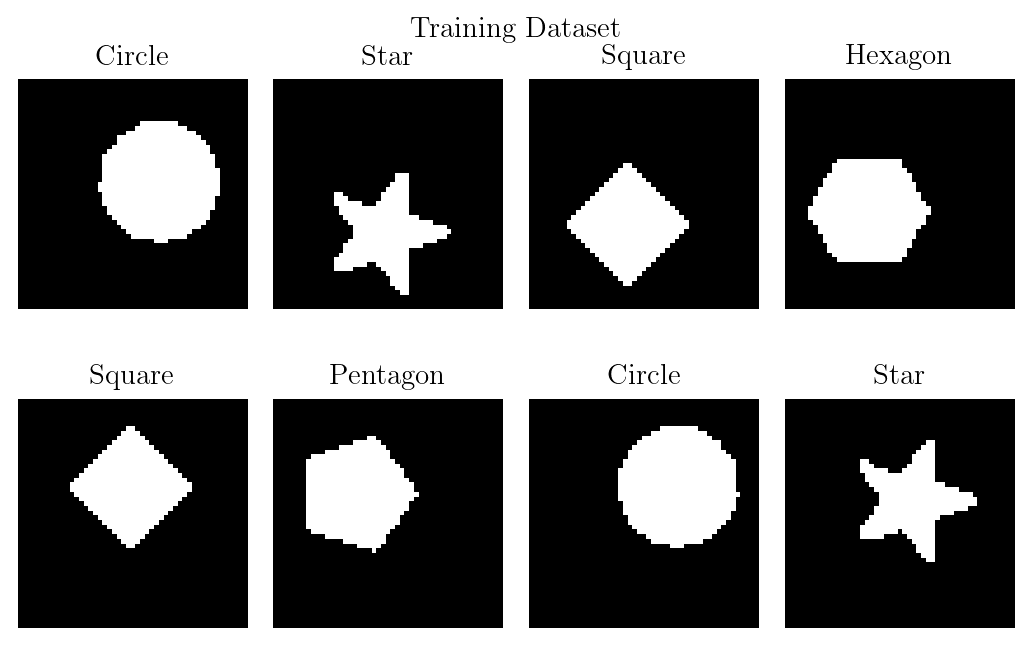

In [6]:
# the visualisation of the dataset is shown

train_features, train_labels = next(iter(train_dataloader))

plt.rc('text', usetex = True)
plt.rc('font', family='serif')
width = 6
height = 4
fig, ax = plt.subplots(2,4)
fig.set_size_inches(width, height) #exact size of the figure
fig.set_dpi(175)

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(train_features[i].permute(1, 2, 0), cmap='gray')
    plt.title(list_of_labels[train_labels[i].argmax().item()])
    plt.axis('off')
plt.tight_layout()
plt.suptitle('Training Dataset')
plt.show()

The geometric shapes that are considered are circle, triangle, square, pentagon, and star. It can be seen that the training dataset doesn't have any rotation transform, therefore the different generations of the same shape has the exactly same rotation. The only difference is the location of the shape on the image.

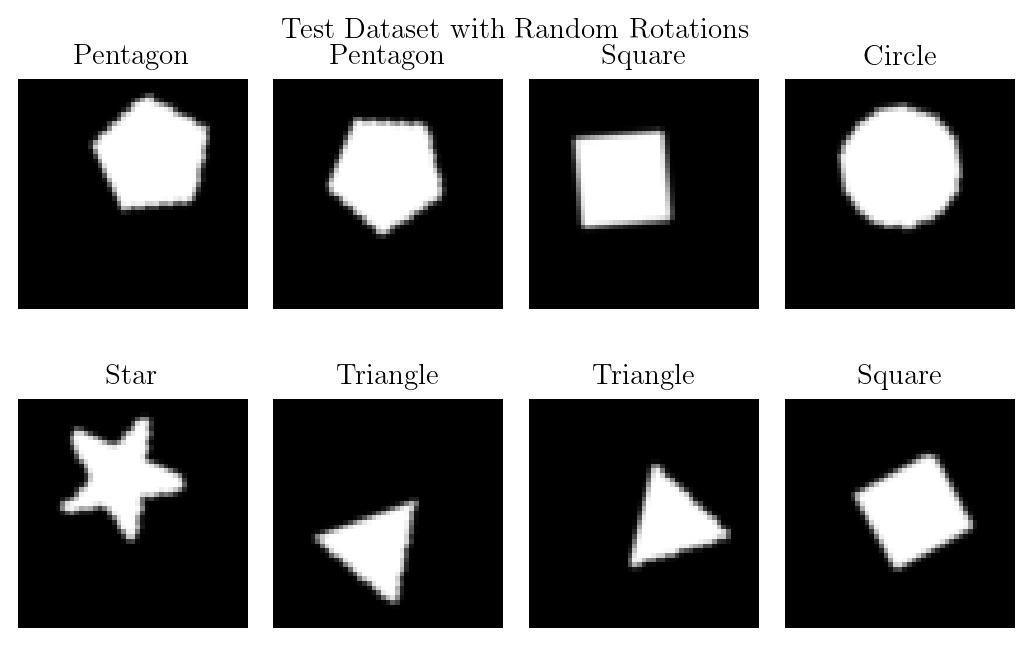

In [7]:
test_features, test_labels = next(iter(test_rotation_dataloader))

width = 6
height = 4
fig, ax = plt.subplots(2,4)
fig.set_size_inches(width, height) #exact size of the figure
fig.set_dpi(175)

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(test_features[i].permute(1, 2, 0), cmap='gray')
    plt.title(list_of_labels[test_labels[i].argmax().item()])
    plt.axis('off')
plt.tight_layout()
plt.suptitle('Test Dataset with Random Rotations')
plt.show()

8 random samples of the test dateset with the rotation transform is plotted above. It can be seen that the geometric shapes have a different rotation than the test dataset. The shapes are protecting their structure and they are still distinguishable. Therefore, we do expect that CNNs should learn the geometry of the shape not the alignment of the shape. To test this goal we will use this random rotation dataset.

## VanillaCNN Initialization and Training

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(1296, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn_vanilla = CNN()
cnn_vanilla.to(device)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1296, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_vanilla.parameters(), lr=0.001)

for epoch in tqdm(range(2)):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn_vanilla(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 1:    # print every 20 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0

print('Finished Training')

model_directory = current_directory+'/models/cnn_vanilla.pth'
torch.save(cnn_vanilla.state_dict(), model_directory)

  0%|          | 0/2 [00:00<?, ?it/s]

[1,     2] loss: 0.390
[1,    22] loss: 1.525
[1,    42] loss: 0.515
[1,    62] loss: 0.086
[1,    82] loss: 0.022


 50%|█████     | 1/2 [00:03<00:03,  3.21s/it]

[2,     2] loss: 0.001
[2,    22] loss: 0.003
[2,    42] loss: 0.001
[2,    62] loss: 0.001
[2,    82] loss: 0.001


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]

Finished Training


VanillaCNN is trained only for 2 epochs and it has a very low loss for the training dataset. It is expected since this training dataset is very simple.

### VanillaCNN Accuracy with the Test Datasets

In [10]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        labels = torch.argmax(labels, dim=1)
        outputs = cnn_vanilla(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

correct = 0
total = 0
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    correct += correct_count
    total += total_pred[classname]

print(f'Accuracy of the network on the 900 test images: {100 * correct // total} %')

Accuracy for class: Triangle is 100.0 %
Accuracy for class: Circle is 100.0 %
Accuracy for class: Square is 100.0 %
Accuracy for class: Star  is 100.0 %
Accuracy for class: Pentagon is 100.0 %
Accuracy for class: Hexagon is 100.0 %
Accuracy of the network on the 900 test images: 100 %


It can be seen that VanillaCNN performs perfectly with the test dataset without rotation. This dataset is generated exactly same way as the training dataset but it has fewer images.

In [11]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_rotation_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        labels = torch.argmax(labels, dim=1)
        outputs = cnn_vanilla(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

correct = 0
total = 0
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    correct += correct_count
    total += total_pred[classname]

print(f'Accuracy of the network on the 900 test images: {100 * correct // total} %')

Accuracy for class: Triangle is 39.0 %
Accuracy for class: Circle is 99.0 %
Accuracy for class: Square is 46.0 %
Accuracy for class: Star  is 84.0 %
Accuracy for class: Pentagon is 48.0 %
Accuracy for class: Hexagon is 18.0 %
Accuracy of the network on the 900 test images: 55 %


VanillaCNN performs poorly for the test dataset with the rotations as expected. It aces the circle class, since the circle shape naturally has a SO2 symmetry. It also does a good job for the star shape. It could be due to the nonconvexity of the star shape. Overall, it has a 55% accuracy. 

## SO2SteerableCNN Initialization and Training

In [12]:
from escnn import group
from escnn import gspaces
from escnn import nn as enn

In [13]:
class SO2SteerableCNN(nn.Module):

    def __init__(self, n_classes=6):

        super(SO2SteerableCNN, self).__init__()

        # the model is equivariant under all planar rotations
        self.r2_act = gspaces.rot2dOnR2(N=-1)

        # the group SO(2)
        self.G: SO2 = self.r2_act.fibergroup

        # the input image is a scalar field, corresponding to the trivial representation
        in_type = enn.FieldType(self.r2_act, [self.r2_act.trivial_repr])

        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type

        # We need to mask the input image since the corners are moved outside the grid under rotations
        self.mask = enn.MaskModule(in_type, 49, margin=1)

        # convolution 1
        # first we build the non-linear layer, which also constructs the right feature type
        # we choose 8 feature fields, each transforming under the regular representation of SO(2) up to frequency 3
        # When taking the ELU non-linearity, we sample the feature fields on N=16 points
        activation1 = enn.FourierELU(self.r2_act, 8, irreps=self.G.bl_irreps(3), N=16, inplace=True)
        out_type = activation1.in_type
        self.block1 = enn.SequentialModule(
            enn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            enn.IIDBatchNorm2d(out_type),
            activation1,
        )

        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the second convolution layer are 16 regular feature fields
        activation2 = enn.FourierELU(self.r2_act, 16, irreps=self.G.bl_irreps(3), N=16, inplace=True)
        out_type = activation2.in_type
        self.block2 = enn.SequentialModule(
            enn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            enn.IIDBatchNorm2d(out_type),
            activation2
        )
        # to reduce the downsampling artifacts, we use a Gaussian smoothing filter
        self.pool1 = enn.SequentialModule(
            enn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )

        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the third convolution layer are 32 regular feature fields
        activation3 = enn.FourierELU(self.r2_act, 32, irreps=self.G.bl_irreps(3), N=16, inplace=True)
        out_type = activation3.in_type
        self.block3 = enn.SequentialModule(
            enn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            enn.IIDBatchNorm2d(out_type),
            activation3
        )

        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the fourth convolution layer are 64 regular feature fields
        activation4 = enn.FourierELU(self.r2_act, 32, irreps=self.G.bl_irreps(3), N=16, inplace=True)
        out_type = activation4.in_type
        self.block4 = enn.SequentialModule(
            enn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            enn.IIDBatchNorm2d(out_type),
            activation4
        )
        self.pool2 = enn.SequentialModule(
            enn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )

        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the fifth convolution layer are 96 regular feature fields
        activation5 = enn.FourierELU(self.r2_act, 64, irreps=self.G.bl_irreps(3), N=16, inplace=True)
        out_type = activation5.in_type
        self.block5 = enn.SequentialModule(
            enn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            enn.IIDBatchNorm2d(out_type),
            activation5
        )

        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields
        activation6 = enn.FourierELU(self.r2_act, 64, irreps=self.G.bl_irreps(3), N=16, inplace=True)
        out_type = activation6.in_type
        self.block6 = enn.SequentialModule(
            enn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            enn.IIDBatchNorm2d(out_type),
            activation6
        )
        self.pool3 = enn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)
        self.pool4 = enn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)
        # number of output invariant channels
        c = 64

        # last 1x1 convolution layer, which maps the regular fields to c=64 invariant scalar fields
        # this is essential to provide *invariant* features in the final classification layer
        output_invariant_type = enn.FieldType(self.r2_act, c*[self.r2_act.trivial_repr])
        self.invariant_map = enn.R2Conv(out_type, output_invariant_type, kernel_size=1, bias=False)

        # Fully Connected classifier
        self.fully_net = nn.Sequential(
            nn.BatchNorm1d(c),
            nn.ELU(inplace=True),
            nn.Linear(c, n_classes),
        )

    def forward(self, input: torch.Tensor):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        x = self.input_type(input)
        # mask out the corners of the input image
        x = self.mask(x)

        # apply each equivariant block

        # Each layer has an input and an output type
        # A layer takes a GeometricTensor in input.
        # This tensor needs to be associated with the same representation of the layer's input type
        #
        # Each layer outputs a new GeometricTensor, associated with the layer's output type.
        # As a result, consecutive layers need to have matching input/output types
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)

        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)

        x = self.block5(x)
        x = self.block6(x)

        # pool over the spatial dimensions
        x = self.pool3(x)
        x = self.pool4(x)

        # extract invariant features
        x = self.invariant_map(x)

        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor

        # classify with the final fully connected layer
        x = self.fully_net(x.reshape(x.shape[0], -1))

        return x

cnn_steerable = SO2SteerableCNN()#instantiate the model
cnn_steerable.to(device)

SO2SteerableCNN(
  (mask): MaskModule()
  (block1): SequentialModule(
    (0): R2Conv([SO(2)_on_R2[(None, -1)]: {irrep_0 (x1)}(1)], [SO(2)_on_R2[(None, -1)]: {regular_[(0,)|(1,)|(2,)|(3,)] (x8)}(56)], kernel_size=7, stride=1, padding=1, bias=False)
    (1): IIDBatchNorm2d([SO(2)_on_R2[(None, -1)]: {regular_[(0,)|(1,)|(2,)|(3,)] (x8)}(56)], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): FourierELU()
  )
  (block2): SequentialModule(
    (0): R2Conv([SO(2)_on_R2[(None, -1)]: {regular_[(0,)|(1,)|(2,)|(3,)] (x8)}(56)], [SO(2)_on_R2[(None, -1)]: {regular_[(0,)|(1,)|(2,)|(3,)] (x16)}(112)], kernel_size=5, stride=1, padding=1, bias=False)
    (1): IIDBatchNorm2d([SO(2)_on_R2[(None, -1)]: {regular_[(0,)|(1,)|(2,)|(3,)] (x16)}(112)], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): FourierELU()
  )
  (pool1): SequentialModule(
    (0): PointwiseAvgPoolAntialiased2D()
  )
  (block3): SequentialModule(
    (0): R2Conv([SO(2)_on_R2[(None, -1)]: {re

In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_steerable.parameters(), lr=0.001)

for epoch in tqdm(range(2)):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn_steerable(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0

print('Finished Training')

model_directory = current_directory+'/models/cnn_steerable.pth'
torch.save(cnn_steerable.state_dict(), model_directory)
     

  0%|          | 0/2 [00:00<?, ?it/s]

[1,    20] loss: 0.952
[1,    40] loss: 0.472
[1,    60] loss: 0.285
[1,    80] loss: 0.193


 50%|█████     | 1/2 [00:11<00:11, 11.05s/it]

[2,    20] loss: 0.091
[2,    40] loss: 0.068
[2,    60] loss: 0.041
[2,    80] loss: 0.027


100%|██████████| 2/2 [00:22<00:00, 11.04s/it]

Finished Training


Like VanillaCNN, SO2SteerableCNN is trained only for 2 epochs and it has a very low loss for the training dataset. It is expected since this training dataset is very simple.

In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        labels = torch.argmax(labels, dim=1)
        outputs = cnn_steerable(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

correct = 0
total = 0
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    correct += correct_count
    total += total_pred[classname]

print(f'Accuracy of the network on the 900 test images: {100 * correct // total} %')

Accuracy for class: Triangle is 100.0 %
Accuracy for class: Circle is 100.0 %
Accuracy for class: Square is 100.0 %
Accuracy for class: Star  is 100.0 %
Accuracy for class: Pentagon is 100.0 %
Accuracy for class: Hexagon is 100.0 %
Accuracy of the network on the 900 test images: 100 %


It can be seen that SO2SteerableCNN performs perfectly with the test dataset without rotation.

In [16]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_rotation_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        labels = torch.argmax(labels, dim=1)
        outputs = cnn_steerable(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

correct = 0
total = 0
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    correct += correct_count
    total += total_pred[classname]

print(f'Accuracy of the network on the 900 test images: {100 * correct // total} %')

Accuracy for class: Triangle is 100.0 %
Accuracy for class: Circle is 100.0 %
Accuracy for class: Square is 100.0 %
Accuracy for class: Star  is 100.0 %
Accuracy for class: Pentagon is 100.0 %
Accuracy for class: Hexagon is 100.0 %
Accuracy of the network on the 900 test images: 100 %


SO2SteerableCNN performs quite better than VanillaCNN for the rotated test dataset! It can be seen that the overall accuraccy increased and all the shapes has a reasonable accuracy level.

### Confusion Matrices and Visualization of Accuracies

In [17]:
confusion_matrix_clean_vanilla = torch.zeros(6, 6)
confusion_matrix_clean_steerable = torch.zeros(6, 6)

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        labels = torch.argmax(labels, dim=1)
        outputs = cnn_vanilla(images)
        _, predictions_vanilla = torch.max(outputs, 1)
        outputs = cnn_steerable(images)
        _, predictions_steerable = torch.max(outputs, 1)
        for t, p, s in zip(labels.view(-1), predictions_vanilla.view(-1), predictions_steerable.view(-1)):
                confusion_matrix_clean_vanilla[t.long(), p.long()] += 1
                confusion_matrix_clean_steerable[t.long(), s.long()] += 1

confusion_matrix_clean_vanilla = confusion_matrix_clean_vanilla.numpy()
confusion_matrix_clean_steerable = confusion_matrix_clean_steerable.numpy()

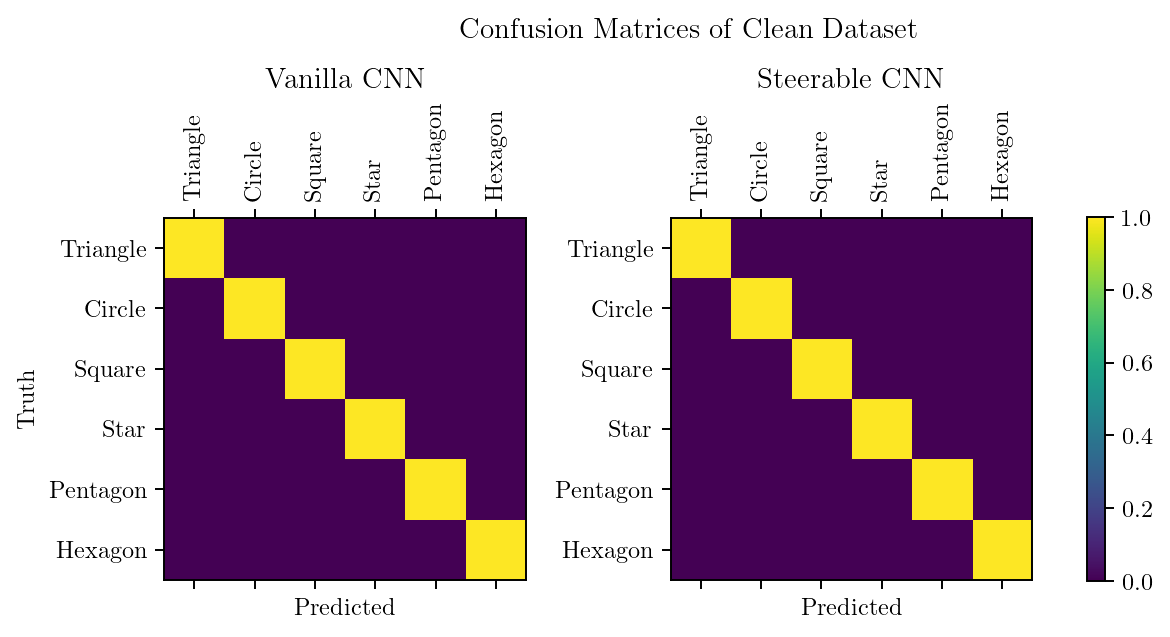

In [18]:
width = 8
height = 4.5
fig, ax = plt.subplots(1,2)
fig.set_size_inches(width, height) #exact size of the figure
fig.set_dpi(175)


# normalize each row
confusion_matrix_clean_vanilla = confusion_matrix_clean_vanilla / confusion_matrix_clean_vanilla.sum(1)
confusion_matrix_clean_steerable = confusion_matrix_clean_steerable / confusion_matrix_clean_steerable.sum(1)


cax = ax[0].matshow(confusion_matrix_clean_vanilla)
ax[0].set_title('Vanilla CNN')
ax[0].set_xticklabels([''] + list_of_labels, rotation=90)
ax[0].set_yticklabels([''] + list_of_labels)
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Truth')

cax = ax[1].matshow(confusion_matrix_clean_steerable)
ax[1].set_title('Steerable CNN')
ax[1].set_xticklabels([''] + list_of_labels, rotation=90)
ax[1].set_yticklabels([''] + list_of_labels)
ax[1].set_xlabel('Predicted')


fig.subplots_adjust(wspace=0.4)
fig.colorbar(cax, ax=ax.ravel().tolist(), shrink=0.6)
# sup title 
fig.suptitle('Confusion Matrices of Clean Dataset')
plt.show()

The confusion matrices for the clean datasets are plotted above. It can be seen that both models are performing well for all the classes.

In [19]:
confusion_matrix_rot_vanilla = torch.zeros(6, 6)
confusion_matrix_rot_steerable = torch.zeros(6, 6)

with torch.no_grad():
    for data in test_rotation_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        labels = torch.argmax(labels, dim=1)
        outputs = cnn_vanilla(images)
        _, predictions_vanilla = torch.max(outputs, 1)
        outputs = cnn_steerable(images)
        _, predictions_steerable = torch.max(outputs, 1)
        for t, p, s in zip(labels.view(-1), predictions_vanilla.view(-1), predictions_steerable.view(-1)):
                confusion_matrix_rot_vanilla[t.long(), p.long()] += 1
                confusion_matrix_rot_steerable[t.long(), s.long()] += 1

confusion_matrix_rot_vanilla = confusion_matrix_rot_vanilla.numpy()
confusion_matrix_rot_steerable = confusion_matrix_rot_steerable.numpy()

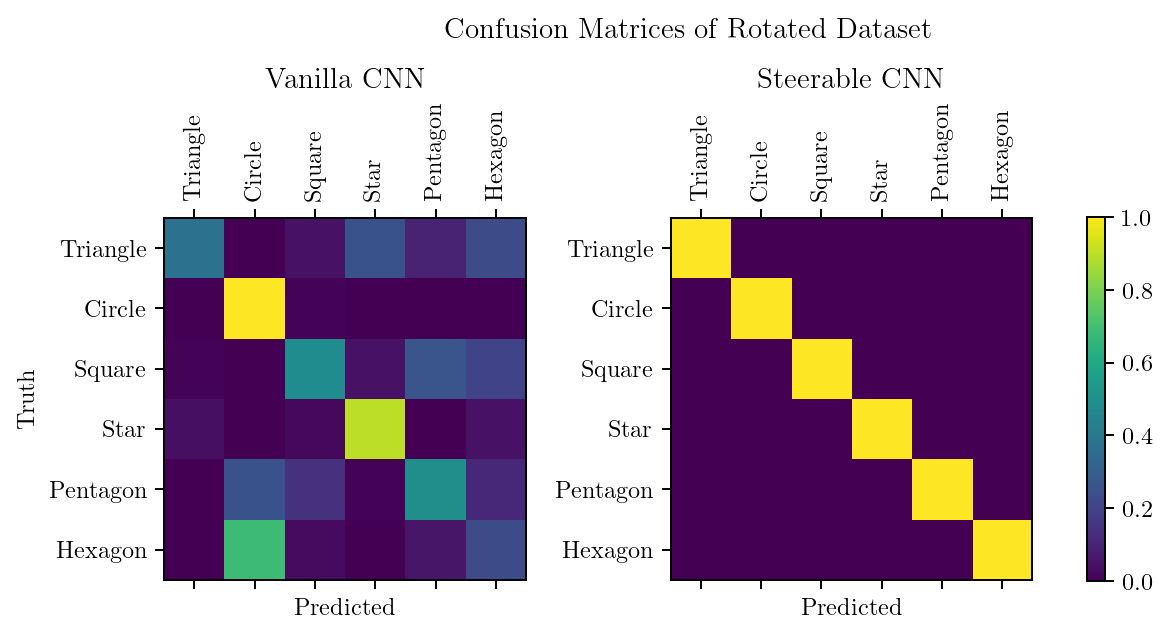

In [20]:
width = 8
height = 4.5
fig, ax = plt.subplots(1,2)
fig.set_size_inches(width, height) #exact size of the figure
fig.set_dpi(175)


# normalize each row
confusion_matrix_rot_vanilla = confusion_matrix_rot_vanilla / confusion_matrix_rot_vanilla.sum(1)
confusion_matrix_rot_steerable = confusion_matrix_rot_steerable / confusion_matrix_rot_steerable.sum(1)


cax = ax[0].matshow(confusion_matrix_rot_vanilla)
ax[0].set_title('Vanilla CNN')
ax[0].set_xticklabels([''] + list_of_labels, rotation=90)
ax[0].set_yticklabels([''] + list_of_labels)
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Truth')

cax = ax[1].matshow(confusion_matrix_rot_steerable)
ax[1].set_title('Steerable CNN')
ax[1].set_xticklabels([''] + list_of_labels, rotation=90)
ax[1].set_yticklabels([''] + list_of_labels)
ax[1].set_xlabel('Predicted')


fig.subplots_adjust(wspace=0.4)
fig.colorbar(cax, ax=ax.ravel().tolist(), shrink=0.6)
# sup title 
fig.suptitle('Confusion Matrices of Rotated Dataset')
plt.show()

The confusion matrices for the test dataset with the rotation is plotted above. It can be seen that SO2Steerable performs well for all the classes. However, VanillaCNN struggles for all the geometric shapes except than circle as expected. It can be seen that it confuses pentagon shape with hexagon. It mostly guesses the hexagons as circles. It could be due to the smoothing effect of upscaling and downscaling. 